## Figure 6: Event Studies of Percent First-Year Enrollments Latinx

from White Flight in Higher Education? The Case of Hispanic-Serving Institutions

by Laura Hamilton, Charlie Eaton, and Simon Cheng

In [1]:
quietly {

set scheme plotplain
    
use data/hdef19902019, clear
keep if ftfeftotlt>100 & ftfeftotlt<.
    
**Create separate unitid for Benjamin Franklin Institute for when it goes from Public to Private
    **Correct IPEDS reporting error to note it is private in 2016 & 2017
replace unitid=unitid+1000000 if unitid==165884 & year>2007
    replace control=2 if unitid==1165884
    
*replace Boricuo college Latinx enrollment as missing for years 1993 & 1994
    * when reporting error reduced % Latinx from 95% to 0%
replace tefhispt=. if unitid==189413 & year<1995 & year>1992
    
foreach var in efbkaat efhispt efwhitt efaiant efasiat {
quietly    gen pctt`var'= t`var' / teftotlt * 100
quietly gen lnftf`var'=log(ftf`var')
    quietly gen lnt`var'=log(t`var')
}
foreach var in cpopam cpopas cpopbl cpopwh cpophi populationam populationas populationbl populationhi populationwh {
        gen ln`var'=log(`var')
    }

quietly gen lnftfeftotlt=log(ftfeftotlt)

**More robust would be discontinuity
quietly gen hispserve=0 if pcttefhispt!=.
quietly replace hispserve=1 if pcttefhispt>=25 & pcttefhispt<.

xtset unitid year

**create var for year in which event occurs observation year of event for subject**
by unitid: gen transition=year if hispserv==1 & l.hispserv==0

**create var for year in which event occurs in all observations for all years for subject**
by unitid: egen hispserveyear = min(transition)

**generate a var for the number of years relative to the year of the event (e.g. + or - 2 years)

gen hispserveyeardiff= year-hispserveyear
    
*bin up year differences larger than absolute value of 10**
replace hispserveyeardiff =10 if hispserveyeardiff <9999 & hispserveyeardiff >10
replace hispserveyeardiff =-10 if hispserveyeardiff <-10
    
** Add 10 to hispserve diff so that all hispserveyear diff values are positive when creating dummy variables
  
replace hispserveyeardiff= hispserveyeardiff+10

gen switchers = (hispserveyeardiff<.)

gen pctlatinx= ftfefhispt / ftfeftotlt * 100
}

In [2]:
qui {

set scheme plotplain
    
local Yvar "pctlatinx"
    local race "Latinx"

  * Public school

    reghdfe `Yvar' b10.hispserveyeardiff lnftfeftotlt lnpop* lncpop* ///
    if switchers==1 & control==1, absorb(unitid year) cluster(unitid)
    estimates store pub

    margins i.hispserveyeardiff

    qui marginsplot, ciopts(recast(rspike)) xline(10, lcolor(gs9) lpattern(dash)) ///
         title("               Public Universities", size(large) margin(small) position(12)) ///
        xtitle(Years from HSI status change, margin(medsmall)) ///
        ytitle(% first-year students, margin(medsmall)) ///
        xlabel(0 "-10" 2 "-8" 4 "-6" 6 "-4" 8 "-2" 10 "0" 12 "2" 14 "4" 16 "6" 18 "8" 20 "10") ///
        name(c1`race'pubpct, replace) 

  * Private school

    reghdfe `Yvar' b10.hispserveyeardiff lnftfeftotlt lnpop* lncpop* ///
    if switchers==1 & control==2, absorb(unitid year) cluster(unitid)
    estimates store pri

    margins i.hispserveyeardiff
    qui marginsplot, ciopts(recast(rspike)) xline(10, lcolor(gs9) lpattern(dash)) ///
        title("               Private Universities", size(large) margin(small) position(12)) ///
        xtitle(Years from HSI status change, margin(medsmall)) ///
        ytitle(% first-year students, margin(medsmall)) ///
        xlabel(0 "-10" 2 "-8" 4 "-6" 6 "-4" 8 "-2" 10 "0" 12 "2" 14 "4" 16 "6" 18 "8" 20 "10") ///
        name(c2`race'pripct, replace) 
}

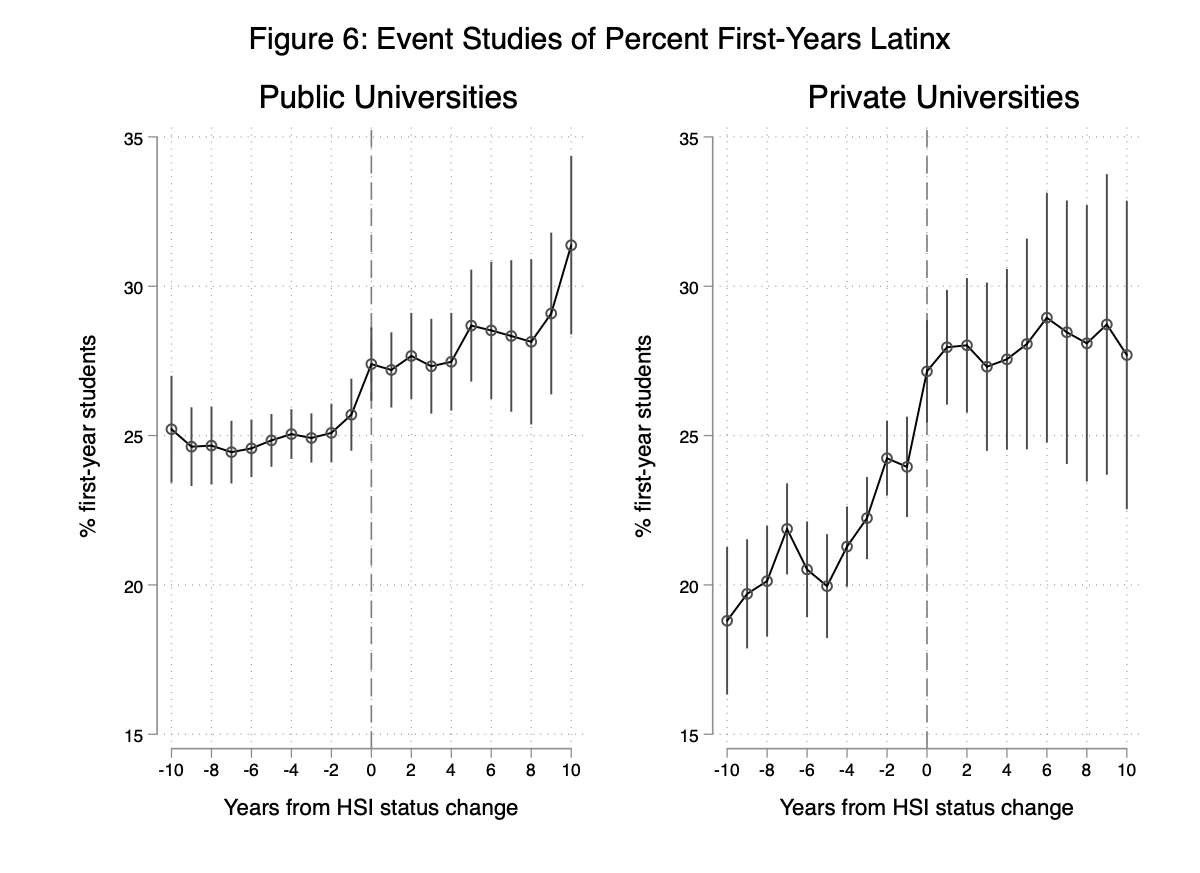

In [3]:
graph combine c1Latinxpubpct c2Latinxpripct,  ycommon /// 
        col(2) xsize(5.5) ysize(4) iscale(*1) imargin(medsmall) graphregion(margin(l=5 r=5)) ///
        title("Figure 6: Event Studies of Percent First-Years Latinx", position(12) size(medsmall) justification(center))

qui graph export figures/f6_pctlatinxeventstudies.pdf, replace